# Pytemoics Practice - 05/15/2020

### The following script utilizes Python & Pyteomics to: 
1. find and open/read a thermo-fisher .raw 'peptide map' data file
2. read in a fasta file with one protein sequence
3. 'digest' the sequence with trypsin
4. calculate the masses of tryptic peptides; 
5. calculate the mass-to-charge of all tryptic peptides assuming that they are ionized with +1 to +3 charge states
6. "Search" the peptide map data for each ion;  
7. answer 'how many of the amino acids (% of total) in your protein did you identify?'
8. answer 'does this % change if you use a different file?'

In [1]:
import os
from urllib.request import urlretrieve
import gzip
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from pyteomics import fasta, parser, mass, achrom, electrochem, auxiliary

In [2]:
# This code is from a Pyteomics example thats downloads a FASTA database. I was not able to run the code
# - I receive an error of 'fails to change directory'. Instead, I downloaded the same file from the website 
# and accessed it from my computer, rather than downloading directly from the server. 

#if not os.path.isfile('yeast.fasta.gz'):
#    print 'Downloading the FASTA file for Saccharomyces cerevisiae...'
#    urlretrieve(
#        'ftp://ftp.uniprot.org/pub/databases/uniprot/current_release/'
#        'knowledgebase/proteomes/YEAST.fasta.gz',
#        'yeast.fasta.gz')
#    print 'Done!'

Example: https://pyteomics.readthedocs.io/en/stable/examples/example_fasta.html

### <font color='blue'> 1) Find and open/read a thermo-fisher .raw 'peptide map' data file </font>

In [3]:
# TBD - see email

I had a hard time finding publically accesible .raw files, but I was able to practice peptide digestion and calculations on fasta files from UniProt: https://www.uniprot.org

In [4]:
# This is how to open/read a FASTA file and print the heading.

with fasta.read('/Users/sarahkurpiers/Documents/Genentech/Raw_Files/yeast.fasta') as yeast:
    print(next(yeast).description)

sp|A0A023PYF4|YE145_YEAST Uncharacterized protein YER145C-A OS=Saccharomyces cerevisiae (strain ATCC 204508 / S288c) (Baker's yeast) OX=559292 GN=SGD:S000028758 PE=3 SV=1


# Part 1: Analyzing an entire FASTA file

This sections analyzes the entire Fasta file for the Baker's yeast proteome - Saccharomyces cerevisiae (strain ATCC 204508 / S288c). Analysis is limited to sequences with less than 100 residues to save time. Future sections focus on just one protein. Here is the link to data used: https://www.uniprot.org/proteomes/UP000002311

In [191]:
# Cleave entire set of proteins and count number of sequences
print('Cleaving the proteins with trypsin...')
unique_peptides = set()
with fasta.read('/Users/sarahkurpiers/Documents/Genentech/Raw_Files/yeast.fasta') as yeast:
    for descr, seq in yeast:
        new_peptides = parser.cleave(seq, parser.expasy_rules['trypsin'])
        unique_peptides.update(new_peptides)
print('Done, {0} sequences obtained!'.format(len(unique_peptides)))

Cleaving the proteins with trypsin...
Done, 188694 sequences obtained!


In [192]:
# Create dict of peptides
peptides = [{'sequence': i} for i in unique_peptides]

# Pre-parse the sequence into individual amino acids, save terminal groups to take into account in mass & charge
# Add sequence and parsed sequence to dict
for peptide in peptides:
    peptide['parsed_sequence'] = parser.parse(peptide['sequence'],show_unmodified_termini=True)
    peptide['length'] = parser.length(peptide['parsed_sequence']) 
    
# Limit to peptides with less than 100 residues
peptides = [peptide for peptide in peptides if peptide['length'] <= 100]

In [193]:
# Add properties to dict including: charge with pH = 2.0, mass, m/z, and 
# retention time in reversed and normal phase chromatography
for peptide in peptides:
    peptide['charge'] = int(round(electrochem.charge(peptide['parsed_sequence'], pH=2.0)))
    peptide['mass'] = mass.calculate_mass(peptide['parsed_sequence'])
    peptide['m/z'] = mass.calculate_mass(peptide['parsed_sequence'], charge=peptide['charge'])
    peptide['RT_RP'] = achrom.calculate_RT(peptide['parsed_sequence'],achrom.RCs_zubarev)
    peptide['RT_normal'] = achrom.calculate_RT(peptide['parsed_sequence'],achrom.RCs_yoshida_lc)

# Create dataframe to store peptide properties in
peptidedf = pd.DataFrame.from_dict(peptides)
peptidedf.head(5)

,RT_RP,RT_normal,charge,length,m/z,mass,parsed_sequence,sequence
0,20.346460,17.775964,3,10,322.498157,964.472643,"[H-, G, H, Q, A, P, A, A, D, A, K, -OH]",GHQAPAADAK
1,73.023985,14.783595,2,19,1071.515499,2141.016444,"[H-, I, S, D, A, Q, N, L, F, S, F, D, L, T, A,...",ISDAQNLFSFDLTAEEVDK
2,35.783249,9.265399,2,6,373.208161,744.401769,"[H-, L, E, L, Q, D, K, -OH]",LELQDK
3,54.488280,12.958482,3,11,452.861891,1355.563843,"[H-, M, F, S, E, H, M, A, D, F, N, K, -OH]",MFSEHMADFNK
4,75.772470,6.625158,2,21,1088.575171,2175.135789,"[H-, F, V, M, N, G, G, L, I, I, G, T, V, D, G,...",FVMNGGLIIGTVDGANVEITR


### Search entire yeast proteome against human:


In [194]:
from pyteomics import mzml, auxiliary, mzxml
with mzxml.read('/Users/sarahkurpiers/Documents/Genentech/Raw_Files/Undepleted Human Serum.mzXML') as reader:
    column_list = auxiliary.print_tree(next(reader))

num
msLevel
peaksCount
polarity
scanType
filterLine
retentionTime
lowMz
highMz
basePeakMz
basePeakIntensity
totIonCurrent
id
m/z array
intensity array


In [200]:
with mzxml.read('/Users/sarahkurpiers/Documents/Genentech/Raw_Files/Undepleted Human Serum.mzXML') as spectra:
    spectrum = next(reader)
spectrum

{'num': '3',
 'msLevel': 1,
 'peaksCount': 370,
 'polarity': '+',
 'scanType': 'CID',
 'filterLine': 'FTMS + p NSI Full ms [350.0000-1600.0000]',
 'retentionTime': 0.014289423466666668 minute,
 'lowMz': 355.068969726563,
 'highMz': 1439.03088378906,
 'basePeakMz': 371.100433349609,
 'basePeakIntensity': 10793725.0,
 'totIonCurrent': 41731732.0,
 'id': '3',
 'm/z array': array([ 355.06897,  356.06787,  356.07327,  356.89926,  357.04874,
         357.06595,  357.07214,  358.06454,  358.45856,  358.88828,
         359.02728,  359.06253,  359.06897,  360.02707,  360.0621 ,
         361.0249 ,  361.22104,  362.22455,  363.11072,  363.25232,
         365.1047 ,  365.97723,  366.9232 ,  367.06927,  367.2683 ,
         367.96545,  368.39777,  368.90213,  368.9191 ,  369.12134,
         369.444  ,  370.12033,  370.4232 ,  370.8821 ,  370.95395,
         371.10043,  371.2776 ,  371.31393,  371.88074,  372.10034,
         372.31747,  373.07974,  373.09705,  373.10266,  373.14798,
         373.321

In [201]:
column_list = []
for key in spectrum:
    column_list.append(key)

# find type of each key
#for key in spectrum:
#    print(type(spectrum[key]))

# convert byte order for np.array entries
# fixed error "Big-endian buffer not supported on little-endian compiler"
spectrum['m/z array'] = spectrum['m/z array'].byteswap().newbyteorder()
spectrum['intensity array'] = spectrum['m/z array'].byteswap().newbyteorder()
spectrum['m/z array'] = spectrum['m/z array'].astype(np.float64)
spectrum['intensity array'] = spectrum['m/z array'].astype(np.float64)
spectrum['m/z array'] = spectrum['m/z array'].astype(str)
spectrum['intensity array'] = spectrum['m/z array'].astype(str)

In [202]:
humandf = pd.DataFrame(spectrum)
humandf
#for column in humandf:
#    if type(humandf[column]) == np.array:
#        humandf[column] = humandf[column].byteswap().newbyteorder()
#        humandf[column] = humandf[column].astype(str)
#        print(humandf[column])

,num,msLevel,peaksCount,polarity,scanType,filterLine,retentionTime,lowMz,highMz,basePeakMz,basePeakIntensity,totIonCurrent,id,m/z array,intensity array
0,3,1,370,+,CID,FTMS + p NSI Full ms [350.0000-1600.0000],0.014289,355.06897,1439.030884,371.100433,10793725.0,41731732.0,3,355.0689697265625,355.0689697265625
1,3,1,370,+,CID,FTMS + p NSI Full ms [350.0000-1600.0000],0.014289,355.06897,1439.030884,371.100433,10793725.0,41731732.0,3,356.06787109375,356.06787109375
2,3,1,370,+,CID,FTMS + p NSI Full ms [350.0000-1600.0000],0.014289,355.06897,1439.030884,371.100433,10793725.0,41731732.0,3,356.0732727050781,356.0732727050781
3,3,1,370,+,CID,FTMS + p NSI Full ms [350.0000-1600.0000],0.014289,355.06897,1439.030884,371.100433,10793725.0,41731732.0,3,356.8992614746094,356.8992614746094
4,3,1,370,+,CID,FTMS + p NSI Full ms [350.0000-1600.0000],0.014289,355.06897,1439.030884,371.100433,10793725.0,41731732.0,3,357.0487365722656,357.0487365722656
5,3,1,370,+,CID,FTMS + p NSI Full ms [350.0000-1600.0000],0.014289,355.06897,1439.030884,371.100433,10793725.0,41731732.0,3,357.0659484863281,357.0659484863281
6,3,1,370,+,CID,FTMS + p NSI Full ms [350.0000-1600.0000],0.014289,355.06897,1439.030884,371.100433,10793725.0,41731732.0,3,357.0721435546875,357.0721435546875
7,3,1,370,+,CID,FTMS + p NSI Full ms [350.0000-1600.0000],0.014289,355.06897,1439.030884,371.100433,10793725.0,41731732.0,3,358.0645446777344,358.0645446777344
8,3,1,370,+,CID,FTMS + p NSI Full ms [350.0000-1600.0000],0.014289,355.06897,1439.030884,371.100433,10793725.0,41731732.0,3,358.45855712890625,358.45855712890625
9,3,1,370,+,CID,FTMS + p NSI Full ms [350.0000-1600.0000],0.014289,355.06897,1439.030884,371.100433,10793725.0,41731732.0,3,358.8882751464844,358.8882751464844


In [203]:
ionlist = peptidedf['m/z'].tolist()
ionlist_rounded = [ '%.1f' % elem for elem in ionlist ]
ionlist_rounded

['322.5',
 '1071.5',
 '373.2',
 '452.9',
 '1088.6',
 '1624.8',
 '1500.8',
 '283.1',
 '725.4',
 '408.8',
 '611.6',
 '387.2',
 '266.2',
 '816.9',
 '867.8',
 '561.8',
 '414.8',
 '604.8',
 '533.3',
 '569.8',
 '994.0',
 '406.7',
 '374.2',
 '528.8',
 '1573.8',
 '318.4',
 '280.2',
 '556.6',
 '890.0',
 '430.7',
 '483.3',
 '246.5',
 '279.2',
 '822.0',
 '788.9',
 '254.6',
 '508.7',
 '611.3',
 '551.8',
 '1895.0',
 '688.9',
 '230.1',
 '358.7',
 '1169.5',
 '471.8',
 '748.4',
 '1018.5',
 '521.6',
 '754.9',
 '563.3',
 '286.5',
 '831.4',
 '2365.6',
 '541.8',
 '481.9',
 '384.9',
 '1063.5',
 '426.0',
 '4482.9',
 '294.7',
 '801.4',
 '803.4',
 '994.5',
 '352.7',
 '353.7',
 '1017.0',
 '1314.1',
 '1272.6',
 '943.8',
 '373.2',
 '474.2',
 '1369.7',
 '693.1',
 '304.2',
 '739.9',
 '349.5',
 '428.7',
 '438.2',
 '487.9',
 '401.7',
 '1371.6',
 '355.2',
 '537.6',
 '1035.2',
 '484.2',
 '387.7',
 '632.3',
 '366.2',
 '551.3',
 '430.6',
 '276.2',
 '365.7',
 '681.8',
 '638.3',
 '642.3',
 '443.7',
 '299.2',
 '252.1',
 '3

In [204]:
searchdf = pd.DataFrame()
for i in ionlist_rounded:
    iondf = humandf.loc[humandf['m/z array'].str.match(i)]
    searchdf = pd.concat([searchdf, iondf])
searchdf

,num,msLevel,peaksCount,polarity,scanType,filterLine,retentionTime,lowMz,highMz,basePeakMz,basePeakIntensity,totIonCurrent,id,m/z array,intensity array
185,3,1,370,+,CID,FTMS + p NSI Full ms [350.0000-1600.0000],0.014289,355.06897,1439.030884,371.100433,10793725.0,41731732.0,3,483.36669921875,483.36669921875
175,3,1,370,+,CID,FTMS + p NSI Full ms [350.0000-1600.0000],0.014289,355.06897,1439.030884,371.100433,10793725.0,41731732.0,3,471.869384765625,471.869384765625
243,3,1,370,+,CID,FTMS + p NSI Full ms [350.0000-1600.0000],0.014289,355.06897,1439.030884,371.100433,10793725.0,41731732.0,3,537.9452514648438,537.9452514648438
87,3,1,370,+,CID,FTMS + p NSI Full ms [350.0000-1600.0000],0.014289,355.06897,1439.030884,371.100433,10793725.0,41731732.0,3,399.3458557128906,399.3458557128906
72,3,1,370,+,CID,FTMS + p NSI Full ms [350.0000-1600.0000],0.014289,355.06897,1439.030884,371.100433,10793725.0,41731732.0,3,391.28326416015625,391.28326416015625
239,3,1,370,+,CID,FTMS + p NSI Full ms [350.0000-1600.0000],0.014289,355.06897,1439.030884,371.100433,10793725.0,41731732.0,3,535.8734130859375,535.8734130859375
310,3,1,370,+,CID,FTMS + p NSI Full ms [350.0000-1600.0000],0.014289,355.06897,1439.030884,371.100433,10793725.0,41731732.0,3,659.893798828125,659.893798828125
136,3,1,370,+,CID,FTMS + p NSI Full ms [350.0000-1600.0000],0.014289,355.06897,1439.030884,371.100433,10793725.0,41731732.0,3,446.8623962402344,446.8623962402344
94,3,1,370,+,CID,FTMS + p NSI Full ms [350.0000-1600.0000],0.014289,355.06897,1439.030884,371.100433,10793725.0,41731732.0,3,409.2698669433594,409.2698669433594
150,3,1,370,+,CID,FTMS + p NSI Full ms [350.0000-1600.0000],0.014289,355.06897,1439.030884,371.100433,10793725.0,41731732.0,3,455.2664489746094,455.2664489746094


# Part 2, One Protein Sequence: Protein 1

To answer your questions, I chose the first sequence from the Baker's yeast proteome by indexing a dataframe of all of the sequences.

### <font color='blue'> 2) Read in a fasta file with just one protein sequence  </font> 

In [8]:
unique_proteins1 = []
with fasta.read('/Users/sarahkurpiers/Documents/Genentech/Raw_Files/yeast.fasta') as yeast:
    for descr, seq in yeast:
        unique_proteins1.append(seq)
proteindf1 = pd.DataFrame(unique_proteins1, columns = ['Sequence'])
protein1 = proteindf1.iloc[0,0]
protein1

'MAILLPLKSILPWCCITFSFLLSSSGSISHSTASSSITLTKSSKPTNVPSNSRFDCSTINTFWLIVLSMTSKGKISGRLILRASVYACECTCIRYACCETIYPPRKPFSLSLYFFYFNKKASILFCYPDAKTKPEHPGNKRAGSG'

### <font color='blue'> 3) 'Digest' the sequence with trypsin  </font> 

In [9]:
# 'Digest' the sequence with trypsin
unique_peptides1 = set()
new_peptides1 = parser.cleave(protein1, parser.expasy_rules['trypsin'])
unique_peptides1.update(new_peptides1)
unique_peptides1

{'AGSG',
 'ASILFCYPDAK',
 'ASVYACECTCIR',
 'FDCSTINTFWLIVLSMTSK',
 'GK',
 'ISGR',
 'K',
 'KPFSLSLYFFYFNK',
 'LILR',
 'MAILLPLK',
 'R',
 'SILPWCCITFSFLLSSSGSISHSTASSSITLTK',
 'SSKPTNVPSNSR',
 'TKPEHPGNK',
 'YACCETIYPPR'}

In [10]:
# Create dict of peptides
peptides1 = [{'Sequence': i} for i in unique_peptides1]

### <font color='blue'> 4) Calculate the masses of tryptic peptides  </font> 

In [11]:
# Calculate the masses of tryptic peptides and assign to dataframe
for peptide in peptides1:
    peptide['parsed_sequence'] = parser.parse(peptide['Sequence'],show_unmodified_termini=True)
    peptide['length'] = parser.length(peptide['parsed_sequence']) 
    peptide['Mass'] = mass.calculate_mass(peptide['parsed_sequence'])
peptidemass1 = pd.DataFrame(peptides1)
columns_to_keep = ['Sequence', 'Mass']
peptidemass1 = peptidemass1[columns_to_keep]
peptidemass1 = peptidemass1.set_index('Sequence')
peptidemass1

,Mass
Sequence,
K,146.105528
KPFSLSLYFFYFNK,1799.928679
ASVYACECTCIR,1317.551564
SSKPTNVPSNSR,1272.642227
AGSG,290.122634
TKPEHPGNK,1006.519593
MAILLPLK,897.572146
LILR,513.363868
GK,203.126991


### <font color='blue'> 5) Calculate the mass-to-charge of all tryptic peptides assuming they are ionized with +1 to +3 charge states  </font> 

In [12]:
# Create dataframe with mass-to-charge of all tryptic peptides assuming they are ionized with +1 to +3 charge states
for peptide in peptides1:
    peptide['parsed_sequence'] = parser.parse(peptide['Sequence'],show_unmodified_termini=True)
    peptide['length'] = parser.length(peptide['parsed_sequence']) 
    peptide['Mass'] = mass.calculate_mass(peptide['parsed_sequence'])
    peptide['M/z +1 charge state'] = mass.calculate_mass(peptide['parsed_sequence'], charge=1)
    peptide['M/z +2 charge state'] = mass.calculate_mass(peptide['parsed_sequence'], charge=2)
    peptide['M/z +3 charge state'] = mass.calculate_mass(peptide['parsed_sequence'], charge=3)
peptidemz1 = pd.DataFrame(peptides1)
columns_to_keep = ['Sequence', 'Mass', 'M/z +1 charge state', 'M/z +2 charge state', 'M/z +3 charge state']
peptidemz1 = peptidemz1[columns_to_keep]
peptidemz1 = peptidemz1.set_index('Sequence')
peptidemz1

,Mass,M/z +1 charge state,M/z +2 charge state,M/z +3 charge state
Sequence,,,,
K,146.105528,147.112804,74.060040,49.709119
KPFSLSLYFFYFNK,1799.928679,1800.935956,900.971616,600.983503
ASVYACECTCIR,1317.551564,1318.558840,659.783058,440.191131
SSKPTNVPSNSR,1272.642227,1273.649504,637.328390,425.221352
AGSG,290.122634,291.129911,146.068594,97.714821
TKPEHPGNK,1006.519593,1007.526869,504.267073,336.513807
MAILLPLK,897.572146,898.579423,449.793350,300.197992
LILR,513.363868,514.371144,257.689210,172.128566
GK,203.126991,204.134268,102.570772,68.716274


### <font color='blue'> 6) 'Search' the peptide map data for each ion </font>  

Raw file: Human Undepleted Serum

In [13]:
from pyteomics import mzml, auxiliary, mzxml
with mzxml.read('/Users/sarahkurpiers/Documents/Genentech/Raw_Files/Undepleted Human Serum.mzXML') as reader:
    column_list = auxiliary.print_tree(next(reader))

num
msLevel
peaksCount
polarity
scanType
filterLine
retentionTime
lowMz
highMz
basePeakMz
basePeakIntensity
totIonCurrent
id
m/z array
intensity array


In [14]:
with mzxml.read('/Users/sarahkurpiers/Documents/Genentech/Raw_Files/Undepleted Human Serum.mzXML') as spectra:
    spectrum = next(reader)
spectrum

{'num': '2',
 'msLevel': 1,
 'peaksCount': 368,
 'polarity': '+',
 'scanType': 'CID',
 'filterLine': 'FTMS + p NSI Full ms [350.0000-1600.0000]',
 'retentionTime': 0.007835525333333334 minute,
 'lowMz': 354.903381347656,
 'highMz': 1500.8994140625,
 'basePeakMz': 371.1005859375,
 'basePeakIntensity': 10568044.0,
 'totIonCurrent': 39477020.0,
 'id': '2',
 'm/z array': array([ 354.90338,  355.0691 ,  356.06805,  357.04892,  357.06607,
         357.07224,  357.43567,  357.9277 ,  358.04797,  358.06458,
         358.07098,  358.88824,  358.92453,  359.02747,  359.0454 ,
         359.0631 ,  359.0694 ,  360.027  ,  360.8841 ,  361.02487,
         361.2211 ,  361.89304,  362.22482,  363.1112 ,  363.25244,
         364.25543,  364.89938,  365.10422,  366.92255,  367.2688 ,
         368.90317,  368.9581 ,  369.1238 ,  369.8864 ,  370.12112,
         370.1278 ,  370.88232,  370.9016 ,  370.95352,  371.1006 ,
         371.31396,  371.88077,  372.10046,  372.3174 ,  372.45142,
         372.90247,

In [15]:
column_list = []
for key in spectrum:
    column_list.append(key)

# find type of each key
#for key in spectrum:
#    print(type(spectrum[key]))

# convert byte order for np.array entries
# fixed error "Big-endian buffer not supported on little-endian compiler"
spectrum['m/z array'] = spectrum['m/z array'].byteswap().newbyteorder()
spectrum['intensity array'] = spectrum['m/z array'].byteswap().newbyteorder()
spectrum['m/z array'] = spectrum['m/z array'].astype(np.float64)
spectrum['intensity array'] = spectrum['m/z array'].astype(np.float64)
spectrum['m/z array'] = spectrum['m/z array'].astype(str)
spectrum['intensity array'] = spectrum['m/z array'].astype(str)

In [16]:
humandf = pd.DataFrame(spectrum)
humandf
#for column in humandf:
#    if type(humandf[column]) == np.array:
#        humandf[column] = humandf[column].byteswap().newbyteorder()
#        humandf[column] = humandf[column].astype(str)
#        print(humandf[column])

,num,msLevel,peaksCount,polarity,scanType,filterLine,retentionTime,lowMz,highMz,basePeakMz,basePeakIntensity,totIonCurrent,id,m/z array,intensity array
0,2,1,368,+,CID,FTMS + p NSI Full ms [350.0000-1600.0000],0.007836,354.903381,1500.899414,371.100586,10568044.0,39477020.0,2,354.90338134765625,354.90338134765625
1,2,1,368,+,CID,FTMS + p NSI Full ms [350.0000-1600.0000],0.007836,354.903381,1500.899414,371.100586,10568044.0,39477020.0,2,355.069091796875,355.069091796875
2,2,1,368,+,CID,FTMS + p NSI Full ms [350.0000-1600.0000],0.007836,354.903381,1500.899414,371.100586,10568044.0,39477020.0,2,356.06805419921875,356.06805419921875
3,2,1,368,+,CID,FTMS + p NSI Full ms [350.0000-1600.0000],0.007836,354.903381,1500.899414,371.100586,10568044.0,39477020.0,2,357.0489196777344,357.0489196777344
4,2,1,368,+,CID,FTMS + p NSI Full ms [350.0000-1600.0000],0.007836,354.903381,1500.899414,371.100586,10568044.0,39477020.0,2,357.0660705566406,357.0660705566406
5,2,1,368,+,CID,FTMS + p NSI Full ms [350.0000-1600.0000],0.007836,354.903381,1500.899414,371.100586,10568044.0,39477020.0,2,357.0722351074219,357.0722351074219
6,2,1,368,+,CID,FTMS + p NSI Full ms [350.0000-1600.0000],0.007836,354.903381,1500.899414,371.100586,10568044.0,39477020.0,2,357.4356689453125,357.4356689453125
7,2,1,368,+,CID,FTMS + p NSI Full ms [350.0000-1600.0000],0.007836,354.903381,1500.899414,371.100586,10568044.0,39477020.0,2,357.9277038574219,357.9277038574219
8,2,1,368,+,CID,FTMS + p NSI Full ms [350.0000-1600.0000],0.007836,354.903381,1500.899414,371.100586,10568044.0,39477020.0,2,358.0479736328125,358.0479736328125
9,2,1,368,+,CID,FTMS + p NSI Full ms [350.0000-1600.0000],0.007836,354.903381,1500.899414,371.100586,10568044.0,39477020.0,2,358.0645751953125,358.0645751953125


In [17]:
# checking if search works using known value
searchdf = humandf.loc[humandf['m/z array'].str.match('354')]
searchdf

,num,msLevel,peaksCount,polarity,scanType,filterLine,retentionTime,lowMz,highMz,basePeakMz,basePeakIntensity,totIonCurrent,id,m/z array,intensity array
0,2,1,368,+,CID,FTMS + p NSI Full ms [350.0000-1600.0000],0.007836,354.903381,1500.899414,371.100586,10568044.0,39477020.0,2,354.90338134765625,354.90338134765625


In [18]:
ionlist = peptidemz1['M/z +1 charge state'].tolist()
ionlist_rounded = [ '%.3f' % elem for elem in ionlist ]
ionlist_rounded

['147.113',
 '1800.936',
 '1318.559',
 '1273.650',
 '291.130',
 '1007.527',
 '898.579',
 '514.371',
 '204.134',
 '3461.733',
 '175.119',
 '1227.608',
 '1315.581',
 '2206.092',
 '432.257']

In [19]:
for i in ionlist_rounded:
    searchdf = humandf.loc[humandf['m/z array'].str.match(i)]
searchdf

,num,msLevel,peaksCount,polarity,scanType,filterLine,retentionTime,lowMz,highMz,basePeakMz,basePeakIntensity,totIonCurrent,id,m/z array,intensity array


In [ ]:
## Conclusion: No similar peptides between this protein and human proteome

### <font color='blue'> 7) How many amino acids (% of total) are in the protein? </font>  

In [14]:
# Determine amino acid composition of the protein
aacomp1 = parser.amino_acid_composition(protein1)
aacomp1

BasicComposition({'M': 2, 'A': 8, 'I': 12, 'L': 14, 'P': 10, 'K': 11, 'S': 24, 'W': 2, 'C': 9, 'T': 11, 'F': 9, 'G': 6, 'H': 2, 'N': 5, 'V': 3, 'R': 6, 'D': 2, 'Y': 6, 'E': 3})

In [15]:
type(aacomp1)

pyteomics.auxiliary.structures.BasicComposition

In [16]:
# Split dictionary into keys and values
aakeys1 = aacomp1.keys() 
aavalues1 = aacomp1.values()

# Create DataFrame for amino acids in protein
aacompdf1 = pd.DataFrame(aavalues1, index = aakeys1)
aacompdf1 = aacompdf1.rename_axis('Yeast Protein 1 Amino Acids')
aacompdf1 = aacompdf1.rename(columns={0: 'Number of Residues'})

# Calculate individual amino acid % of total
aacompdf1['% of Total'] = (aacompdf1['Number of Residues'])/(aacompdf1['Number of Residues'].sum())*100
aacompdf1

,Number of Residues,% of Total
Yeast Protein 1 Amino Acids,,
M,2,1.379310
A,8,5.517241
I,12,8.275862
L,14,9.655172
P,10,6.896552
K,11,7.586207
S,24,16.551724
W,2,1.379310
C,9,6.206897


### <font color='blue'> 8) Does this % change if you use a different file? </font>  

Yes, the % of each amino acid changes using different files. See below:

## Protein 2
#### I repeated the pocess using E.Coli and selecting the first protein sequence. Here is the link to Escherichia coli (strain K12) data used: https://www.uniprot.org/proteomes/UP000000625

In [28]:
# Read in a fasta file with just one protein sequence
unique_proteins2 = []
with fasta.read('/Users/sarahkurpiers/Documents/Genentech/Raw_Files/ECOLI.fasta') as ecoli:
    for descr, seq in ecoli:
        unique_proteins2.append(seq)
proteindf2 = pd.DataFrame(unique_proteins2, columns = ['Sequence'])
ecoliprotein1 = proteindf2.iloc[0,0]
ecoliprotein1

'MPVLQWGMLCVLSLLLSIGFLAVHLPAALLLGPMIAGIIFSMRGITLQLPRSAFLAAQAILGCMIAQNLTGSILTTLAVNWPIVLAILLVTLLSSAIVGWLLVRYSSLPGNTGAWGSSPGGAAAMVAMAQDYGADIRLVAFMQYLRVLFVAGAAVLVTRMMLGDNAEAVNQHIVWFPPVSINLLLTILLAVVAGTVGCLLRLPSGTMLIPMLAGAVLQSGQLITIELPEWLLAMAYMAIGWRIGLGFDKQILLRALRPLPQILLSIFALLAICAGMAWGLTRFMHIDFMTAYLATSPGGLDTVAVIAAGSNADMALIMAMQTLRLFSILLTGPAIARFISTYAPKRSA'

In [29]:
# 'Digest' the sequence with trypsin
unique_peptides2 = set()
new_peptides2 = parser.cleave(ecoliprotein1, parser.expasy_rules['trypsin'])
unique_peptides2.update(new_peptides2)
unique_peptides2

{'ALRPLPQILLSIFALLAICAGMAWGLTR',
 'FISTYAPK',
 'FMHIDFMTAYLATSPGGLDTVAVIAAGSNADMALIMAMQTLR',
 'GITLQLPR',
 'IGLGFDK',
 'LFSILLTGPAIAR',
 'LPSGTMLIPMLAGAVLQSGQLITIELPEWLLAMAYMAIGWR',
 'LVAFMQYLR',
 'MMLGDNAEAVNQHIVWFPPVSINLLLTILLAVVAGTVGCLLR',
 'MPVLQWGMLCVLSLLLSIGFLAVHLPAALLLGPMIAGIIFSMR',
 'QILLR',
 'R',
 'SA',
 'SAFLAAQAILGCMIAQNLTGSILTTLAVNWPIVLAILLVTLLSSAIVGWLLVR',
 'VLFVAGAAVLVTR',
 'YSSLPGNTGAWGSSPGGAAAMVAMAQDYGADIR'}

In [30]:
# Create dict of peptides
peptides2 = [{'Sequence': i} for i in unique_peptides2]

In [31]:
# Calculate the masses of tryptic peptides
for peptide in peptides2:
    peptide['parsed_sequence'] = parser.parse(peptide['Sequence'],show_unmodified_termini=True)
    peptide['length'] = parser.length(peptide['parsed_sequence']) 
    peptide['Mass'] = mass.calculate_mass(peptide['parsed_sequence'])
peptidemass2 = pd.DataFrame(peptides2)
columns_to_keep = ['Sequence', 'Mass']
peptidemass2 = peptidemass2[columns_to_keep]
peptidemass2 = peptidemass2.set_index('Sequence')
peptidemass2.head(4)

,Mass
Sequence,
FISTYAPK,925.490919
GITLQLPR,896.544351
LPSGTMLIPMLAGAVLQSGQLITIELPEWLLAMAYMAIGWR,4454.364222
IGLGFDK,748.411940


In [32]:
# Calculate the mass-to-charge of all tryptic peptides assuming they are ionized with +1 to +3 charge states
for peptide in peptides2:
    peptide['parsed_sequence'] = parser.parse(peptide['Sequence'],show_unmodified_termini=True)
    peptide['length'] = parser.length(peptide['parsed_sequence']) 
    peptide['Mass'] = mass.calculate_mass(peptide['parsed_sequence'])
    peptide['M/z +1 charge state'] = mass.calculate_mass(peptide['parsed_sequence'], charge=1)
    peptide['M/z +2 charge state'] = mass.calculate_mass(peptide['parsed_sequence'], charge=2)
    peptide['M/z +3 charge state'] = mass.calculate_mass(peptide['parsed_sequence'], charge=3)
peptidemz2 = pd.DataFrame(peptides2)
columns_to_keep = ['Sequence', 'Mass', 'M/z +1 charge state', 'M/z +2 charge state', 'M/z +3 charge state']
peptidemz2 = peptidemz2[columns_to_keep]
peptidemz2 = peptidemz2.set_index('Sequence')
peptidemz2.head(4)

,Mass,M/z +1 charge state,M/z +2 charge state,M/z +3 charge state
Sequence,,,,
FISTYAPK,925.490919,926.498195,463.752736,309.504249
GITLQLPR,896.544351,897.551628,449.279452,299.855394
LPSGTMLIPMLAGAVLQSGQLITIELPEWLLAMAYMAIGWR,4454.364222,4455.371498,2228.189387,1485.795350
IGLGFDK,748.411940,749.419216,375.213246,250.477923


In [33]:
# "Search" the peptide map data for each ion
# TBD

### Search E.coli peptides against human:


In [34]:
from pyteomics import mzml, auxiliary, mzxml
with mzxml.read('/Users/sarahkurpiers/Documents/Genentech/Raw_Files/Undepleted Human Serum.mzXML') as reader:
    column_list = auxiliary.print_tree(next(reader))

num
msLevel
peaksCount
polarity
scanType
filterLine
retentionTime
lowMz
highMz
basePeakMz
basePeakIntensity
totIonCurrent
id
m/z array
intensity array


In [35]:
with mzxml.read('/Users/sarahkurpiers/Documents/Genentech/Raw_Files/Undepleted Human Serum.mzXML') as spectra:
    spectrum = next(reader)
spectrum

{'num': '2',
 'msLevel': 1,
 'peaksCount': 368,
 'polarity': '+',
 'scanType': 'CID',
 'filterLine': 'FTMS + p NSI Full ms [350.0000-1600.0000]',
 'retentionTime': 0.007835525333333334 minute,
 'lowMz': 354.903381347656,
 'highMz': 1500.8994140625,
 'basePeakMz': 371.1005859375,
 'basePeakIntensity': 10568044.0,
 'totIonCurrent': 39477020.0,
 'id': '2',
 'm/z array': array([ 354.90338,  355.0691 ,  356.06805,  357.04892,  357.06607,
         357.07224,  357.43567,  357.9277 ,  358.04797,  358.06458,
         358.07098,  358.88824,  358.92453,  359.02747,  359.0454 ,
         359.0631 ,  359.0694 ,  360.027  ,  360.8841 ,  361.02487,
         361.2211 ,  361.89304,  362.22482,  363.1112 ,  363.25244,
         364.25543,  364.89938,  365.10422,  366.92255,  367.2688 ,
         368.90317,  368.9581 ,  369.1238 ,  369.8864 ,  370.12112,
         370.1278 ,  370.88232,  370.9016 ,  370.95352,  371.1006 ,
         371.31396,  371.88077,  372.10046,  372.3174 ,  372.45142,
         372.90247,

In [36]:
column_list = []
for key in spectrum:
    column_list.append(key)

# find type of each key
#for key in spectrum:
#    print(type(spectrum[key]))

# convert byte order for np.array entries
# fixed error "Big-endian buffer not supported on little-endian compiler"
spectrum['m/z array'] = spectrum['m/z array'].byteswap().newbyteorder()
spectrum['intensity array'] = spectrum['m/z array'].byteswap().newbyteorder()
spectrum['m/z array'] = spectrum['m/z array'].astype(np.float64)
spectrum['intensity array'] = spectrum['m/z array'].astype(np.float64)
spectrum['m/z array'] = spectrum['m/z array'].astype(str)
spectrum['intensity array'] = spectrum['m/z array'].astype(str)

In [37]:
humandf = pd.DataFrame(spectrum)
humandf
#for column in humandf:
#    if type(humandf[column]) == np.array:
#        humandf[column] = humandf[column].byteswap().newbyteorder()
#        humandf[column] = humandf[column].astype(str)
#        print(humandf[column])

,num,msLevel,peaksCount,polarity,scanType,filterLine,retentionTime,lowMz,highMz,basePeakMz,basePeakIntensity,totIonCurrent,id,m/z array,intensity array
0,2,1,368,+,CID,FTMS + p NSI Full ms [350.0000-1600.0000],0.007836,354.903381,1500.899414,371.100586,10568044.0,39477020.0,2,354.90338134765625,354.90338134765625
1,2,1,368,+,CID,FTMS + p NSI Full ms [350.0000-1600.0000],0.007836,354.903381,1500.899414,371.100586,10568044.0,39477020.0,2,355.069091796875,355.069091796875
2,2,1,368,+,CID,FTMS + p NSI Full ms [350.0000-1600.0000],0.007836,354.903381,1500.899414,371.100586,10568044.0,39477020.0,2,356.06805419921875,356.06805419921875
3,2,1,368,+,CID,FTMS + p NSI Full ms [350.0000-1600.0000],0.007836,354.903381,1500.899414,371.100586,10568044.0,39477020.0,2,357.0489196777344,357.0489196777344
4,2,1,368,+,CID,FTMS + p NSI Full ms [350.0000-1600.0000],0.007836,354.903381,1500.899414,371.100586,10568044.0,39477020.0,2,357.0660705566406,357.0660705566406
5,2,1,368,+,CID,FTMS + p NSI Full ms [350.0000-1600.0000],0.007836,354.903381,1500.899414,371.100586,10568044.0,39477020.0,2,357.0722351074219,357.0722351074219
6,2,1,368,+,CID,FTMS + p NSI Full ms [350.0000-1600.0000],0.007836,354.903381,1500.899414,371.100586,10568044.0,39477020.0,2,357.4356689453125,357.4356689453125
7,2,1,368,+,CID,FTMS + p NSI Full ms [350.0000-1600.0000],0.007836,354.903381,1500.899414,371.100586,10568044.0,39477020.0,2,357.9277038574219,357.9277038574219
8,2,1,368,+,CID,FTMS + p NSI Full ms [350.0000-1600.0000],0.007836,354.903381,1500.899414,371.100586,10568044.0,39477020.0,2,358.0479736328125,358.0479736328125
9,2,1,368,+,CID,FTMS + p NSI Full ms [350.0000-1600.0000],0.007836,354.903381,1500.899414,371.100586,10568044.0,39477020.0,2,358.0645751953125,358.0645751953125


In [38]:
ionlist = peptidemz2['M/z +1 charge state'].tolist()
ionlist_rounded = [ '%.3f' % elem for elem in ionlist ]
ionlist_rounded

['926.498',
 '897.552',
 '4455.371',
 '749.419',
 '1140.623',
 '3229.468',
 '642.430',
 '4416.157',
 '4605.579',
 '5532.187',
 '1315.810',
 '177.087',
 '3008.730',
 '175.119',
 '1371.836',
 '4501.454']

In [39]:
for i in ionlist_rounded:
    searchdf = humandf.loc[humandf['m/z array'].str.match(i)]
searchdf

,num,msLevel,peaksCount,polarity,scanType,filterLine,retentionTime,lowMz,highMz,basePeakMz,basePeakIntensity,totIonCurrent,id,m/z array,intensity array


In [24]:
# How many amino acids (% of total) are in the protein?

# Determine amino acid composition of the protein
aacomp2 = parser.amino_acid_composition(ecoliprotein1)
aacomp2

# split dictionary into keys and values
aakeys2 = aacomp2.keys() 
aavalues2 = aacomp2.values()

# create DataFrame for amino acids in protein
aacompdf2 = pd.DataFrame(aavalues2, index = aakeys2)
aacompdf2 = aacompdf2.rename_axis('E.Coli Protein 1 Amino Acids')
aacompdf2 = aacompdf2.rename(columns={0: 'Number of Residues'})

# Calculate individual amino acid % of total
aacompdf2['% of Total'] = (aacompdf2['Number of Residues'])/(aacompdf2['Number of Residues'].sum())*100
aacompdf2

,Number of Residues,% of Total
E.Coli Protein 1 Amino Acids,,
M,20,5.747126
P,17,4.885057
V,23,6.609195
L,63,18.103448
Q,12,3.448276
W,8,2.298851
G,30,8.620690
C,4,1.149425
S,20,5.747126


##### Finally, I used this process on a single protein FASTA, rather than selecting one protein from a full proteome file.

## Protein 3 - Acetyl-coenzyme A carboxylase carboxyl transferase subunit beta, chloroplastic

When using UniProt, the Fasta of just one protein downloads to a web archive file. This makes the heading hard to deal with, and it becomes a part of the sequence when trying to iterate (see first code box). To fix this, I stripped the characters from before and after the amino acid sequence. (This is not very efficient for future files, but I could not figure out a better way to deal with the format at the moment.) https://www.uniprot.org/uniprot/A6MML6

In [40]:
# Read in a fasta file with just one protein sequence
# add encoding = latin-1 to get rid of byte errors
with fasta.read('/Users/sarahkurpiers/Documents/Genentech/Raw_Files/A6MML6.fasta', encoding='latin-1') as protein3:
    for descr, seq in protein3:
        print('From web:', seq)
seq = seq.strip('^WebResourceURL_WebResourceFrameName_WebResourceData_WebResourceMIMEType_WebResourceTextEncodingName_,https://www.uniprot.org/uniprot/A6MML6.fastaPOø<html><head></head><body><pre style="word-wrap: break-word; white-space: pre-wrap;">&gt;sp|A6MML6|ACCD_DIOEL Acetyl-coenzyme A carboxylase carboxyl transferase subunit beta, chloroplastic OS=Dioscorea elephantipes OX=145284 GN=accD PE=3 S')
seq = seq.rstrip('</body></html>Ztext/plainUUTF-8\x00\x08\x00\x00\x00(\x007\x00N\x00`\x00v\x00\x94\x00Ã\x00Ä\x03À\x03Ë\x00\x00\x00\x00\x00\x00\x02\x01\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x03Ñ')
seq = seq.strip('V=2')
seq = seq.rstrip('</pr')
print('')
print('Stripped sequence:', seq)

From web: ^WebResourceURL_WebResourceFrameName_WebResourceData_WebResourceMIMEType_WebResourceTextEncodingName_,https://www.uniprot.org/uniprot/A6MML6.fastaPOø<html><head></head><body><pre style="word-wrap: break-word; white-space: pre-wrap;">&gt;sp|A6MML6|ACCD_DIOEL Acetyl-coenzyme A carboxylase carboxyl transferase subunit beta, chloroplastic OS=Dioscorea elephantipes OX=145284 GN=accD PE=3 SV=2MEKWWWFNSILSNERLEHRYGLSKSMDSVNGIEYTKDPILNDTEKNILGWSDSSNYSFSTVDYLFEIRNIWSLISDDTFLVRDSNGDSYSVYFDIENQIFEIDNNSSFLGELESFFSSYLNRGSKNKYYHYMYDTQFSWNNHITNCIDSYLRFEIGISITSYISGDIVNYSDGYIYSFICTESVSSNESGSSSIRTSSNGSDFNMRENSNDSDINKKYRHLWVQCENCYGLNYKKFFRSKMNICEQCGYHLKMSSSDRIEVSIDPDTWDPMDEDMVSIDPIEFHSEEEPYRDRIDSYQRKTGLTEAIQTGIGQLNGIPIAIGVMDFQFMGGSMGSVVGEKITRLIEYATNESLPVIIVCASGGARMQEGSLSLMQMAKISSASYNYQSNKKLFYVSILTSPTTGGVTASFGMLGDVIIAEPNAYIAFAGKRVIEQTLNKTVPDGSQSAEYLFHKGLFDPIVPRNPLKGVLSELFQLHGFLPLNQNKKEN</pre></body></html>Ztext/plainUUTF-8    ( 7 N ` v  Ã ÄÀË                           Ñ

Stripp

In [41]:
# 'Digest' the sequence with trypsin
print('Cleaving the protein with trypsin...')
unique_peptides3 = set()
new_peptides3 = parser.cleave(seq, parser.expasy_rules['trypsin'])
unique_peptides3.update(new_peptides3)
print('Done, {0} sequences obtained!'.format(len(unique_peptides3)))
unique_peptides3

Cleaving the protein with trypsin...
Done, 38 sequences obtained!


{'DPILNDTEK',
 'DR',
 'DSNGDSYSVYFDIENQIFEIDNNSSFLGELESFFSSYLNR',
 'EN',
 'ENSNDSDINK',
 'FEIGISITSYISGDIVNYSDGYIYSFICTESVSSNESGSSSIR',
 'FFR',
 'GLFDPIVPR',
 'GSK',
 'GVLSELFQLHGFLPLNQNK',
 'HLWVQCENCYGLNYK',
 'IDSYQR',
 'IEVSIDPDTWDPMDEDMVSIDPIEFHSEEEPYR',
 'ISSASYNYQSNK',
 'ITR',
 'K',
 'LEHR',
 'LFYVSILTSPTTGGVTASFGMLGDVIIAEPNAYIAFAGK',
 'LIEYATNESLPVIIVCASGGAR',
 'MEK',
 'MNICEQCGYHLK',
 'MQEGSLSLMQMAK',
 'MSSSDR',
 'NILGWSDSSNYSFSTVDYLFEIR',
 'NIWSLISDDTFLVR',
 'NK',
 'NPLK',
 'R',
 'SK',
 'SMDSVNGIEYTK',
 'TGLTEAIQTGIGQLNGIPIAIGVMDFQFMGGSMGSVVGEK',
 'TSSNGSDFNMR',
 'TVPDGSQSAEYLFHK',
 'VIEQTLNK',
 'WWWFNSILSNER',
 'YGLSK',
 'YR',
 'YYHYMYDTQFSWNNHITNCIDSYLR'}

In [42]:
# Create dict of peptides
peptides3 = [{'Sequence': i} for i in unique_peptides3]

In [43]:
# Calculate the masses of tryptic peptides
for peptide in peptides3:
    peptide['parsed_sequence'] = parser.parse(peptide['Sequence'],show_unmodified_termini=True)
    peptide['length'] = parser.length(peptide['parsed_sequence']) 
    peptide['mass'] = mass.calculate_mass(peptide['parsed_sequence'])
peptidemass3 = pd.DataFrame(peptides3)
columns_to_keep = ['Sequence', 'mass']
peptidemass3 = peptidemass3[columns_to_keep]
peptidemass3 = peptidemass3.set_index('Sequence')
peptidemass3.head(4)

,mass
Sequence,
TSSNGSDFNMR,1214.498600
MNICEQCGYHLK,1437.620312
K,146.105528
YYHYMYDTQFSWNNHITNCIDSYLR,3246.396390


In [44]:
# Calculate the mass-to-charge of all tryptic peptides assuming they are ionized with +1 and +3 charge states
for peptide in peptides3:
    peptide['parsed_sequence'] = parser.parse(peptide['Sequence'],show_unmodified_termini=True)
    peptide['length'] = parser.length(peptide['parsed_sequence']) 
    peptide['Mass'] = mass.calculate_mass(peptide['parsed_sequence'])
    peptide['M/z +1 charge state'] = mass.calculate_mass(peptide['parsed_sequence'], charge=1)
    peptide['M/z +2 charge state'] = mass.calculate_mass(peptide['parsed_sequence'], charge=2)
    peptide['M/z +3 charge state'] = mass.calculate_mass(peptide['parsed_sequence'], charge=3)
peptidemz3 = pd.DataFrame(peptides3)
columns_to_keep = ['Sequence', 'Mass', 'M/z +1 charge state', 'M/z +2 charge state', 'M/z +3 charge state']
peptidemz3 = peptidemz3[columns_to_keep]
peptidemz3 = peptidemz3.set_index('Sequence')
peptidemz3.head(4)

,Mass,M/z +1 charge state,M/z +2 charge state,M/z +3 charge state
Sequence,,,,
TSSNGSDFNMR,1214.498600,1215.505876,608.256576,405.840143
MNICEQCGYHLK,1437.620312,1438.627589,719.817433,480.214047
K,146.105528,147.112804,74.060040,49.709119
YYHYMYDTQFSWNNHITNCIDSYLR,3246.396390,3247.403667,1624.205472,1083.139407


In [45]:
# "Search" the peptide map data for each ion

In [46]:
from pyteomics import mzml, auxiliary, mzxml
with mzxml.read('/Users/sarahkurpiers/Documents/Genentech/Raw_Files/Undepleted Human Serum.mzXML') as reader:
    column_list = auxiliary.print_tree(next(reader))

num
msLevel
peaksCount
polarity
scanType
filterLine
retentionTime
lowMz
highMz
basePeakMz
basePeakIntensity
totIonCurrent
id
m/z array
intensity array


In [47]:
with mzxml.read('/Users/sarahkurpiers/Documents/Genentech/Raw_Files/Undepleted Human Serum.mzXML') as spectra:
    spectrum = next(reader)
spectrum

{'num': '2',
 'msLevel': 1,
 'peaksCount': 368,
 'polarity': '+',
 'scanType': 'CID',
 'filterLine': 'FTMS + p NSI Full ms [350.0000-1600.0000]',
 'retentionTime': 0.007835525333333334 minute,
 'lowMz': 354.903381347656,
 'highMz': 1500.8994140625,
 'basePeakMz': 371.1005859375,
 'basePeakIntensity': 10568044.0,
 'totIonCurrent': 39477020.0,
 'id': '2',
 'm/z array': array([ 354.90338,  355.0691 ,  356.06805,  357.04892,  357.06607,
         357.07224,  357.43567,  357.9277 ,  358.04797,  358.06458,
         358.07098,  358.88824,  358.92453,  359.02747,  359.0454 ,
         359.0631 ,  359.0694 ,  360.027  ,  360.8841 ,  361.02487,
         361.2211 ,  361.89304,  362.22482,  363.1112 ,  363.25244,
         364.25543,  364.89938,  365.10422,  366.92255,  367.2688 ,
         368.90317,  368.9581 ,  369.1238 ,  369.8864 ,  370.12112,
         370.1278 ,  370.88232,  370.9016 ,  370.95352,  371.1006 ,
         371.31396,  371.88077,  372.10046,  372.3174 ,  372.45142,
         372.90247,

In [48]:
column_list = []
for key in spectrum:
    column_list.append(key)

# find type of each key
#for key in spectrum:
#    print(type(spectrum[key]))

# convert byte order for np.array entries
# fixed error "Big-endian buffer not supported on little-endian compiler"
spectrum['m/z array'] = spectrum['m/z array'].byteswap().newbyteorder()
spectrum['intensity array'] = spectrum['m/z array'].byteswap().newbyteorder()
spectrum['m/z array'] = spectrum['m/z array'].astype(np.float64)
spectrum['intensity array'] = spectrum['m/z array'].astype(np.float64)
spectrum['m/z array'] = spectrum['m/z array'].astype(str)
spectrum['intensity array'] = spectrum['m/z array'].astype(str)

In [49]:
humandf = pd.DataFrame(spectrum)
humandf
#for column in humandf:
#    if type(humandf[column]) == np.array:
#        humandf[column] = humandf[column].byteswap().newbyteorder()
#        humandf[column] = humandf[column].astype(str)
#        print(humandf[column])

,num,msLevel,peaksCount,polarity,scanType,filterLine,retentionTime,lowMz,highMz,basePeakMz,basePeakIntensity,totIonCurrent,id,m/z array,intensity array
0,2,1,368,+,CID,FTMS + p NSI Full ms [350.0000-1600.0000],0.007836,354.903381,1500.899414,371.100586,10568044.0,39477020.0,2,354.90338134765625,354.90338134765625
1,2,1,368,+,CID,FTMS + p NSI Full ms [350.0000-1600.0000],0.007836,354.903381,1500.899414,371.100586,10568044.0,39477020.0,2,355.069091796875,355.069091796875
2,2,1,368,+,CID,FTMS + p NSI Full ms [350.0000-1600.0000],0.007836,354.903381,1500.899414,371.100586,10568044.0,39477020.0,2,356.06805419921875,356.06805419921875
3,2,1,368,+,CID,FTMS + p NSI Full ms [350.0000-1600.0000],0.007836,354.903381,1500.899414,371.100586,10568044.0,39477020.0,2,357.0489196777344,357.0489196777344
4,2,1,368,+,CID,FTMS + p NSI Full ms [350.0000-1600.0000],0.007836,354.903381,1500.899414,371.100586,10568044.0,39477020.0,2,357.0660705566406,357.0660705566406
5,2,1,368,+,CID,FTMS + p NSI Full ms [350.0000-1600.0000],0.007836,354.903381,1500.899414,371.100586,10568044.0,39477020.0,2,357.0722351074219,357.0722351074219
6,2,1,368,+,CID,FTMS + p NSI Full ms [350.0000-1600.0000],0.007836,354.903381,1500.899414,371.100586,10568044.0,39477020.0,2,357.4356689453125,357.4356689453125
7,2,1,368,+,CID,FTMS + p NSI Full ms [350.0000-1600.0000],0.007836,354.903381,1500.899414,371.100586,10568044.0,39477020.0,2,357.9277038574219,357.9277038574219
8,2,1,368,+,CID,FTMS + p NSI Full ms [350.0000-1600.0000],0.007836,354.903381,1500.899414,371.100586,10568044.0,39477020.0,2,358.0479736328125,358.0479736328125
9,2,1,368,+,CID,FTMS + p NSI Full ms [350.0000-1600.0000],0.007836,354.903381,1500.899414,371.100586,10568044.0,39477020.0,2,358.0645751953125,358.0645751953125


In [50]:
ionlist = peptidemz3['M/z +1 charge state'].tolist()
ionlist_rounded = [ '%.3f' % elem for elem in ionlist ]
ionlist_rounded

['1215.506',
 '1438.628',
 '147.113',
 '3247.404',
 '471.293',
 '554.305',
 '2713.278',
 '469.256',
 '3935.715',
 '682.282',
 '1135.486',
 '1343.615',
 '3992.077',
 '4024.023',
 '175.119',
 '1013.578',
 '338.182',
 '389.251',
 '1361.633',
 '1453.685',
 '1678.807',
 '781.384',
 '1044.521',
 '944.541',
 '1678.880',
 '234.145',
 '290.146',
 '567.314',
 '1637.786',
 '291.166',
 '2276.195',
 '4647.161',
 '262.103',
 '2154.171',
 '1869.841',
 '261.156',
 '407.196',
 '4662.074']

In [51]:
for i in ionlist_rounded:
    searchdf = humandf.loc[humandf['m/z array'].str.match(i)]
searchdf

,num,msLevel,peaksCount,polarity,scanType,filterLine,retentionTime,lowMz,highMz,basePeakMz,basePeakIntensity,totIonCurrent,id,m/z array,intensity array


In [36]:
# How many amino acids (% of total) are in the protein?

# Determine amino acod composition
aacomp3 = parser.amino_acid_composition(seq)
aacomp3

# Split dictionary into keys and values
aakeys3 = aacomp3.keys() 
aavalues3 = aacomp3.values()

# Sreate DataFrame for amino acids in protein
aacompdf3 = pd.DataFrame(aavalues3, index = aakeys3)
aacompdf3 = aacompdf3.rename_axis('Acetyl-coenzyme A Amino Acids')
aacompdf3 = aacompdf3.rename(columns={0: 'Number of Residues'})

# Calculate individual amino acid % of total
aacompdf3['% of Total'] = (aacompdf3['Number of Residues'])/(aacompdf3['Number of Residues'].sum())*100
aacompdf3

,Number of Residues,% of Total
Acetyl-coenzyme A Amino Acids,,
M,15,3.067485
E,32,6.543967
K,23,4.703476
W,8,1.635992
F,25,5.112474
N,36,7.361963
S,64,13.087935
I,43,8.793456
L,33,6.748466


In [50]:
from pyteomics import mgf, pepxml
import pylab

# Part 3: Reading in a MGF file and comparing to pepXML identification info

In [47]:
# Defines function that will give m/z of theoretical fragments for a given sequence. 
# pyteomics.mass.fast_mass() is used to calculate. The sequence is split at every bond and the function 
# iterates over possible charges and ion types

def fragments(peptide, types=('b', 'y'), maxcharge=3):
    """
    The function generates all possible m/z for fragments of types 
    `types` and of charges from 1 to `maxcharge`.
    """
    for i in xrange(1, len(peptide)-1):
        for ion_type in types:
            for charge in xrange(1, maxcharge+1):
                if ion_type[0] in 'abc':
                    yield mass.fast_mass(
                            peptide[:i], ion_type=ion_type, charge=charge)
                else:
                    yield mass.fast_mass(
                            peptide[i:], ion_type=ion_type, charge=charge)

In [44]:
with mgf.read('/Users/sarahkurpiers/Documents/Genentech/example.mgf') as spectra, pepxml.read('/Users/sarahkurpiers/Documents/Genentech/example.pep.xml') as psms:
    spectrum = next(spectra)
    psm = next(psms)
spectrum

{'params': {'title': 'GPAAIQK', 'pepmass': (342.70559, None), 'charge': [2]},
 'm/z array': array([155.08127, 176.77814, 177.11287, 226.11824, 229.64627, 265.16449,
        265.66641, 269.16089, 275.1712 , 297.15521, 314.19504, 314.69733,
        325.18619, 343.20746, 343.70929, 382.2438 , 388.25513, 389.25903,
        392.22888, 408.18784, 409.19104, 410.23959, 411.24402, 457.28772,
        459.29205, 460.29568, 493.27762, 513.3031 , 520.28723, 521.27124,
        522.27612, 530.32843, 531.33197, 532.33423, 536.24768, 538.29736,
        539.30054, 540.31415, 554.29248, 555.29999, 556.30743]),
 'intensity array': array([  2297.6,   7543.8,   2635.6,   5689.8,   5041.8,  17045.5,
          3543.8,   3408.9,   2846.8,   8410.6,   6265.5,   2129. ,
          3157.4,   4456.9,   4044.3,   3641.6,  42239.4,   6749.8,
          2317.6,   9400.2,   2566.7,  20488. ,   4645. ,   4824.5,
        139345.9,  35741.9,   3401.2,   6745.2,   2995.6,  10339.9,
          2187.7, 378102.2, 120362.4,   4

In [45]:
psm

{'spectrum': '',
 'precursor_neutral_mass': 683.3966,
 'assumed_charge': 2,
 'start_scan': 1,
 'end_scan': 1,
 'index': 1,
 'search_hit': [{'hit_rank': 1,
   'peptide': 'GPAAIQK',
   'num_tot_proteins': 1,
   'num_matched_ions': 8,
   'tot_num_ions': 12,
   'num_missed_cleavages': 0,
   'search_score': {'hyperscore': 23.2,
    'nextscore': 17.3,
    'bscore': 6.6,
    'yscore': 12.1,
    'cscore': 0.0,
    'zscore': 0.0,
    'ascore': 0.0,
    'xscore': 0.0,
    'expect': 1.3},
   'calc_neutral_pep_mass': 683.3966,
   'massdiff': 0.0,
   'is_rejected': False,
   'proteins': [{'protein': 'sp|P35527|K1C9_HUMAN',
     'protein_descr': 'Keratin, type I cytoskeletal 9 OS=Homo sapiens GN=KRT9 PE=1 SV=3',
     'peptide_next_aa': 'N',
     'peptide_prev_aa': 'K',
     'num_tol_term': 2}],
   'modified_peptide': 'GPAAIQK',
   'modifications': []}]}

<BarContainer object of 41 artists>

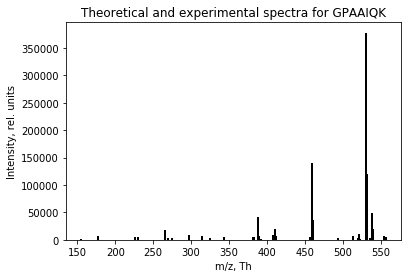

In [51]:
# Prepare figure
pylab.figure()
pylab.title('Theoretical and experimental spectra for '
        + psm['search_hit'][0]['peptide'])
pylab.xlabel('m/z, Th')
pylab.ylabel('Intensity, rel. units')

# Plot real spectrum
pylab.bar(spectrum['m/z array'], spectrum['intensity array'], width=0.1, linewidth=2,
        edgecolor='black')

In [55]:
try:
    # Python 2
    xrange
except NameError:
    # Python 3, xrange is now named range
    xrange = range

# Python 2 code that uses xrange(...) unchanged, and any
# range(...) replaced with list(range(...))

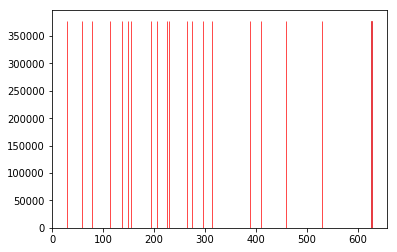

In [54]:
# The most intensive peaks in the spectrum are indeed matched by the theoretical spectrum
theor_spectrum = list(fragments(psm['search_hit'][0]['peptide'],
    maxcharge=psm['assumed_charge']))
pylab.bar(theor_spectrum,
        [spectrum['intensity array'].max()]*len(theor_spectrum),
        width=0.1, edgecolor='red', alpha=0.7)
pylab.show()

# Undepleted Human Serum

In [26]:
from pyteomics import mzml, auxiliary, mzxml
with mzxml.read('/Users/sarahkurpiers/Documents/Genentech/Raw_Files/Undepleted Human Serum.mzXML') as reader:
    auxiliary.print_tree(next(reader))

num
msLevel
peaksCount
polarity
scanType
filterLine
retentionTime
lowMz
highMz
basePeakMz
basePeakIntensity
totIonCurrent
id
m/z array
intensity array


In [30]:
with mzxml.read('/Users/sarahkurpiers/Documents/Genentech/Raw_Files/Undepleted Human Serum.mzXML') as spectra:
    spectrum = next(reader)
spectrum

{'num': '5',
 'msLevel': 1,
 'peaksCount': 387,
 'polarity': '+',
 'scanType': 'CID',
 'filterLine': 'FTMS + p NSI Full ms [350.0000-1600.0000]',
 'retentionTime': 0.026851865616666668 minute,
 'lowMz': 350.452697753906,
 'highMz': 1521.65905761719,
 'basePeakMz': 371.100524902344,
 'basePeakIntensity': 10713273.0,
 'totIonCurrent': 41012008.0,
 'id': '5',
 'm/z array': array([ 350.4527 ,  352.02078,  353.88254,  355.0691 ,  356.06793,
         356.07315,  356.56976,  356.93683,  357.04877,  357.066  ,
         357.07217,  358.00638,  358.06448,  358.88815,  359.02737,
         359.06287,  359.06915,  360.02722,  361.02475,  361.22125,
         362.2249 ,  362.65582,  363.1103 ,  363.25244,  364.25516,
         365.8987 ,  365.96317,  366.10757,  366.92282,  367.83392,
         368.90234,  368.95627,  369.0024 ,  369.1213 ,  369.12375,
         369.37207,  369.73047,  370.12045,  370.1273 ,  370.3495 ,
         370.8822 ,  371.10052,  371.31406,  371.8804 ,  372.1004 ,
         372.317

In [32]:
humandf = pd.DataFrame(spectrum)
humandf

,num,msLevel,peaksCount,polarity,scanType,filterLine,retentionTime,lowMz,highMz,basePeakMz,basePeakIntensity,totIonCurrent,id,m/z array,intensity array
0,5,1,387,+,CID,FTMS + p NSI Full ms [350.0000-1600.0000],0.026852,350.452698,1521.659058,371.100525,10713273.0,41012008.0,5,350.452698,7249.017578
1,5,1,387,+,CID,FTMS + p NSI Full ms [350.0000-1600.0000],0.026852,350.452698,1521.659058,371.100525,10713273.0,41012008.0,5,352.020782,7409.562988
2,5,1,387,+,CID,FTMS + p NSI Full ms [350.0000-1600.0000],0.026852,350.452698,1521.659058,371.100525,10713273.0,41012008.0,5,353.882538,7187.891113
3,5,1,387,+,CID,FTMS + p NSI Full ms [350.0000-1600.0000],0.026852,350.452698,1521.659058,371.100525,10713273.0,41012008.0,5,355.069092,541151.312500
4,5,1,387,+,CID,FTMS + p NSI Full ms [350.0000-1600.0000],0.026852,350.452698,1521.659058,371.100525,10713273.0,41012008.0,5,356.067932,453524.062500
5,5,1,387,+,CID,FTMS + p NSI Full ms [350.0000-1600.0000],0.026852,350.452698,1521.659058,371.100525,10713273.0,41012008.0,5,356.073151,53911.125000
6,5,1,387,+,CID,FTMS + p NSI Full ms [350.0000-1600.0000],0.026852,350.452698,1521.659058,371.100525,10713273.0,41012008.0,5,356.569763,6926.684082
7,5,1,387,+,CID,FTMS + p NSI Full ms [350.0000-1600.0000],0.026852,350.452698,1521.659058,371.100525,10713273.0,41012008.0,5,356.936829,9860.592773
8,5,1,387,+,CID,FTMS + p NSI Full ms [350.0000-1600.0000],0.026852,350.452698,1521.659058,371.100525,10713273.0,41012008.0,5,357.048767,44345.593750
9,5,1,387,+,CID,FTMS + p NSI Full ms [350.0000-1600.0000],0.026852,350.452698,1521.659058,371.100525,10713273.0,41012008.0,5,357.066010,473002.375000


# Protein 4: Serum Albumin 

In [82]:
# Cleave entire set of proteins and count number of sequences
print('Cleaving the proteins with trypsin...')
unique_peptides4 = set()
with fasta.read('/Users/sarahkurpiers/Documents/Genentech/Raw_Files/Serum_Albumin2.fasta') as serum:
    for descr, seq in serum:
        new_peptides4 = parser.cleave(seq, parser.expasy_rules['trypsin'])
        unique_peptides4.update(new_peptides4)
print('Done, {0} sequences obtained!'.format(len(unique_peptides4)))

Cleaving the proteins with trypsin...
Done, 73 sequences obtained!


In [83]:
# Create dict of peptides
peptides4 = [{'Sequence': i} for i in unique_peptides4]

In [84]:
# Calculate the masses of tryptic peptides
for peptide in peptides4:
    peptide['parsed_sequence'] = parser.parse(peptide['Sequence'],show_unmodified_termini=True)
    peptide['length'] = parser.length(peptide['parsed_sequence']) 
    peptide['mass'] = mass.calculate_mass(peptide['parsed_sequence'])
peptidemass4 = pd.DataFrame(peptides4)
columns_to_keep = ['Sequence', 'mass']
peptidemass4 = peptidemass4[columns_to_keep]
peptidemass4 = peptidemass4.set_index('Sequence')
peptidemass4.head(4)

,mass
Sequence,
DEGK,447.196528
K,146.105528
LSQR,502.286346
NECFLQHK,1017.470200


In [85]:
# Calculate the mass-to-charge of all tryptic peptides assuming they are ionized with +1 and +3 charge states
for peptide in peptides4:
    peptide['parsed_sequence'] = parser.parse(peptide['Sequence'],show_unmodified_termini=True)
    peptide['length'] = parser.length(peptide['parsed_sequence']) 
    peptide['Mass'] = mass.calculate_mass(peptide['parsed_sequence'])
    peptide['M/z +1 charge state'] = mass.calculate_mass(peptide['parsed_sequence'], charge=1)
    peptide['M/z +2 charge state'] = mass.calculate_mass(peptide['parsed_sequence'], charge=2)
    peptide['M/z +3 charge state'] = mass.calculate_mass(peptide['parsed_sequence'], charge=3)
peptidemz4 = pd.DataFrame(peptides4)
columns_to_keep = ['Sequence', 'Mass', 'M/z +1 charge state', 'M/z +2 charge state', 'M/z +3 charge state']
peptidemz4 = peptidemz4[columns_to_keep]
peptidemz4 = peptidemz4.set_index('Sequence')
peptidemz4.head(4)

,Mass,M/z +1 charge state,M/z +2 charge state,M/z +3 charge state
Sequence,,,,
DEGK,447.196528,448.203804,224.605540,150.072786
K,146.105528,147.112804,74.060040,49.709119
LSQR,502.286346,503.293622,252.150449,168.436058
NECFLQHK,1017.470200,1018.477477,509.742377,340.164010


In [45]:
# "Search" the peptide map data for each ion

In [86]:
from pyteomics import mzml, auxiliary, mzxml
with mzxml.read('/Users/sarahkurpiers/Documents/Genentech/Raw_Files/Undepleted Human Serum.mzXML') as reader:
    column_list = auxiliary.print_tree(next(reader))

num
msLevel
peaksCount
polarity
scanType
filterLine
retentionTime
lowMz
highMz
basePeakMz
basePeakIntensity
totIonCurrent
id
m/z array
intensity array


In [87]:
with mzxml.read('/Users/sarahkurpiers/Documents/Genentech/Raw_Files/Undepleted Human Serum.mzXML') as spectra:
    spectrum = next(reader)
spectrum

{'num': '2',
 'msLevel': 1,
 'peaksCount': 368,
 'polarity': '+',
 'scanType': 'CID',
 'filterLine': 'FTMS + p NSI Full ms [350.0000-1600.0000]',
 'retentionTime': 0.007835525333333334 minute,
 'lowMz': 354.903381347656,
 'highMz': 1500.8994140625,
 'basePeakMz': 371.1005859375,
 'basePeakIntensity': 10568044.0,
 'totIonCurrent': 39477020.0,
 'id': '2',
 'm/z array': array([ 354.90338,  355.0691 ,  356.06805,  357.04892,  357.06607,
         357.07224,  357.43567,  357.9277 ,  358.04797,  358.06458,
         358.07098,  358.88824,  358.92453,  359.02747,  359.0454 ,
         359.0631 ,  359.0694 ,  360.027  ,  360.8841 ,  361.02487,
         361.2211 ,  361.89304,  362.22482,  363.1112 ,  363.25244,
         364.25543,  364.89938,  365.10422,  366.92255,  367.2688 ,
         368.90317,  368.9581 ,  369.1238 ,  369.8864 ,  370.12112,
         370.1278 ,  370.88232,  370.9016 ,  370.95352,  371.1006 ,
         371.31396,  371.88077,  372.10046,  372.3174 ,  372.45142,
         372.90247,

In [88]:
column_list = []
for key in spectrum:
    column_list.append(key)

# find type of each key
#for key in spectrum:
#    print(type(spectrum[key]))

# convert byte order for np.array entries
# fixed error "Big-endian buffer not supported on little-endian compiler"
spectrum['m/z array'] = spectrum['m/z array'].byteswap().newbyteorder()
spectrum['intensity array'] = spectrum['m/z array'].byteswap().newbyteorder()
spectrum['m/z array'] = spectrum['m/z array'].astype(np.float64)
spectrum['intensity array'] = spectrum['m/z array'].astype(np.float64)
spectrum['m/z array'] = spectrum['m/z array'].astype(str)
spectrum['intensity array'] = spectrum['m/z array'].astype(str)

In [179]:
humandf = pd.DataFrame(spectrum)
humandf
#for column in humandf:
#    if type(humandf[column]) == np.array:
#        humandf[column] = humandf[column].byteswap().newbyteorder()
#        humandf[column] = humandf[column].astype(str)
#        print(humandf[column])

,num,msLevel,peaksCount,polarity,scanType,filterLine,retentionTime,lowMz,highMz,basePeakMz,basePeakIntensity,totIonCurrent,id,m/z array,intensity array
0,2,1,368,+,CID,FTMS + p NSI Full ms [350.0000-1600.0000],0.007836,354.903381,1500.899414,371.100586,10568044.0,39477020.0,2,354.90338134765625,354.90338134765625
1,2,1,368,+,CID,FTMS + p NSI Full ms [350.0000-1600.0000],0.007836,354.903381,1500.899414,371.100586,10568044.0,39477020.0,2,355.069091796875,355.069091796875
2,2,1,368,+,CID,FTMS + p NSI Full ms [350.0000-1600.0000],0.007836,354.903381,1500.899414,371.100586,10568044.0,39477020.0,2,356.06805419921875,356.06805419921875
3,2,1,368,+,CID,FTMS + p NSI Full ms [350.0000-1600.0000],0.007836,354.903381,1500.899414,371.100586,10568044.0,39477020.0,2,357.0489196777344,357.0489196777344
4,2,1,368,+,CID,FTMS + p NSI Full ms [350.0000-1600.0000],0.007836,354.903381,1500.899414,371.100586,10568044.0,39477020.0,2,357.0660705566406,357.0660705566406
5,2,1,368,+,CID,FTMS + p NSI Full ms [350.0000-1600.0000],0.007836,354.903381,1500.899414,371.100586,10568044.0,39477020.0,2,357.0722351074219,357.0722351074219
6,2,1,368,+,CID,FTMS + p NSI Full ms [350.0000-1600.0000],0.007836,354.903381,1500.899414,371.100586,10568044.0,39477020.0,2,357.4356689453125,357.4356689453125
7,2,1,368,+,CID,FTMS + p NSI Full ms [350.0000-1600.0000],0.007836,354.903381,1500.899414,371.100586,10568044.0,39477020.0,2,357.9277038574219,357.9277038574219
8,2,1,368,+,CID,FTMS + p NSI Full ms [350.0000-1600.0000],0.007836,354.903381,1500.899414,371.100586,10568044.0,39477020.0,2,358.0479736328125,358.0479736328125
9,2,1,368,+,CID,FTMS + p NSI Full ms [350.0000-1600.0000],0.007836,354.903381,1500.899414,371.100586,10568044.0,39477020.0,2,358.0645751953125,358.0645751953125


In [189]:
ionlist = peptidemz4['M/z +1 charge state'].tolist()
ionlist_rounded = [ '%.1f' % elem for elem in ionlist ]
ionlist_rounded

['448.2',
 '147.1',
 '503.3',
 '1018.5',
 '1191.6',
 '673.4',
 '2845.3',
 '310.2',
 '2760.3',
 '1149.6',
 '880.4',
 '470.2',
 '464.2',
 '940.4',
 '2593.2',
 '388.3',
 '2045.1',
 '1381.5',
 '1600.7',
 '478.3',
 '984.5',
 '698.4',
 '674.3',
 '517.3',
 '649.3',
 '347.2',
 '1386.6',
 '1017.5',
 '431.3',
 '695.3',
 '1320.5',
 '1000.6',
 '876.5',
 '365.2',
 '353.1',
 '331.2',
 '2203.0',
 '1511.8',
 '508.3',
 '2433.3',
 '260.2',
 '951.4',
 '1742.9',
 '1311.7',
 '411.2',
 '319.2',
 '294.2',
 '2037.1',
 '960.6',
 '581.3',
 '789.5',
 '175.1',
 '1013.4',
 '509.3',
 '390.2',
 '1257.5',
 '1915.8',
 '1384.5',
 '448.2',
 '445.3',
 '658.3',
 '463.3',
 '1013.6',
 '1623.8',
 '278.2',
 '645.4',
 '1342.6',
 '304.2',
 '391.2',
 '715.4',
 '2392.1',
 '517.3',
 '927.5']

In [190]:
searchdf = pd.DataFrame()
for i in ionlist_rounded:
    iondf = humandf.loc[humandf['m/z array'].str.match(i)]
    searchdf = pd.concat([searchdf, iondf])
searchdf

,num,msLevel,peaksCount,polarity,scanType,filterLine,retentionTime,lowMz,highMz,basePeakMz,basePeakIntensity,totIonCurrent,id,m/z array,intensity array
73,2,1,368,+,CID,FTMS + p NSI Full ms [350.0000-1600.0000],0.007836,354.903381,1500.899414,371.100586,10568044.0,39477020.0,2,388.34149169921875,388.34149169921875
77,2,1,368,+,CID,FTMS + p NSI Full ms [350.0000-1600.0000],0.007836,354.903381,1500.899414,371.100586,10568044.0,39477020.0,2,391.28338623046875,391.28338623046875


In [186]:
# How many amino acids (% of total) are in the protein?

# Determine amino acod composition
aacomp4 = parser.amino_acid_composition(seq)
aacomp4

# Split dictionary into keys and values
aakeys4 = aacomp4.keys() 
aavalues4 = aacomp4.values()

# Sreate DataFrame for amino acids in protein
aacompdf4 = pd.DataFrame(aavalues4, index = aakeys4)
aacompdf4 = aacompdf4.rename_axis('Acetyl-coenzyme A Amino Acids')
aacompdf4 = aacompdf4.rename(columns={0: 'Number of Residues'})

# Calculate individual amino acid % of total
aacompdf4['% of Total'] = (aacompdf4['Number of Residues'])/(aacompdf4['Number of Residues'].sum())*100
aacompdf4

,Number of Residues,% of Total
Acetyl-coenzyme A Amino Acids,,
M,7,1.149425
K,60,9.852217
W,2,0.328407
V,42,6.896552
T,29,4.761905
F,36,5.911330
I,9,1.477833
S,28,4.597701
L,64,10.509031


## WEB VERSION not complete: Protein 4 - Serum Albumin Fasta Compared to Raw Data

When using UniProt, the Fasta of just one protein downloads to a web archive file. This makes the heading hard to deal with, and it becomes a part of the sequence when trying to iterate (see first code box). To fix this, I stripped the characters from before and after the amino acid sequence. (This is not very efficient for future files, but I could not figure out a better way to deal with the format at the moment.) https://www.uniprot.org/uniprot/A6MML6

In [56]:
# Read in a fasta file with just one protein sequence
# add encoding = latin-1 to get rid of byte errors
with fasta.read('/Users/sarahkurpiers/Documents/Genentech/Raw_Files/Serum_Albumin.fasta', encoding='latin-1') as protein3:
    for descr, seq in protein3:
        print('From web:', seq)
seq = seq.strip('^WebResourceURL_WebResourceFrameName_WebResourceData_WebResourceMIMEType_WebResourceTextEncodingName_,https://www.uniprot.org/uniprot/A6MML6.fastaPOø<html><head></head><body><pre style="word-wrap: break-word; white-space: pre-wrap;">&gt;sp|A6MML6|ACCD_DIOEL Acetyl-coenzyme A carboxylase carboxyl transferase subunit beta, chloroplastic OS=Dioscorea elephantipes OX=145284 GN=accD PE=3 S')
seq = seq.rstrip('</body></html>Ztext/plainUUTF-8\x00\x08\x00\x00\x00(\x007\x00N\x00`\x00v\x00\x94\x00Ã\x00Ä\x03À\x03Ë\x00\x00\x00\x00\x00\x00\x02\x01\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x03Ñ')
seq = seq.strip('V=2')
seq = seq.rstrip('</pr')
print('')
print('Stripped sequence:', seq)

From web: ^WebResourceURL_WebResourceFrameName_WebResourceData_WebResourceMIMEType_WebResourceTextEncodingName_,https://www.uniprot.org/uniprot/Q56G89.fastaPO<html><head></head><body><pre style="word-wrap: break-word; white-space: pre-wrap;">&gt;tr|Q56G89|Q56G89_HUMAN Serum albumin OS=Homo sapiens OX=9606 PE=2 SV=1MKWVTFISLLFLFSSAYSRGVFRRDAHKSEVAHRFKDLGEENFKALVLIAFAQYLQQCPFEDHVKLVNEVTEFAKTCVADESAENCDKSLHTLFGDKLCTVATLRETYGEMADCCAKQEPERNECFLQHKDDNPNLPRLVRPEVDVMCTAFHDNEETFLKKYLYEIARRHPYFYAPELLFFAKRYKAAFTECCQAADKAACLLPKLDELRDEGKASSAKQGLKCASLQKFGERAFKAWAVARLSQRFPKAEFAEVSKLVTDLTKVHTECCHGDLLECADDRADLAKYICENQDSISSKLKECCEKPLLEKSHCIAEVENDEMPADLPSLAADFVGSKDVCKNYAEAKDVFLGMFLYEYARRHPDYSVVLLLRLAKTYETTLEKCCAAADPHECYAKVFDEFKPLVEEPQNLIKQNCELFEQLGEYKFQNALLVRYTKKVPQVSTPTLVEVSRNLGKVGSKCCKHPEAKRMPCAEDCLSVFLNQLCVLHEKTPVSDRVTKCCTESLVNGRPCFSALEVDETYVPKEFNAETFTFHADICTLSEKERQIKKQTALVELVKHKPKATKEQLKAVMDDFAAFVEKCCKADDKETCFAEEGKKLVAASQAALGL</pre></body></html>Ztext/plainUUTF-8    ( 7 N ` v  Ã Äçò  

In [41]:
# 'Digest' the sequence with trypsin
print('Cleaving the protein with trypsin...')
unique_peptides3 = set()
new_peptides3 = parser.cleave(seq, parser.expasy_rules['trypsin'])
unique_peptides3.update(new_peptides3)
print('Done, {0} sequences obtained!'.format(len(unique_peptides3)))
unique_peptides3

Cleaving the protein with trypsin...
Done, 38 sequences obtained!


{'DPILNDTEK',
 'DR',
 'DSNGDSYSVYFDIENQIFEIDNNSSFLGELESFFSSYLNR',
 'EN',
 'ENSNDSDINK',
 'FEIGISITSYISGDIVNYSDGYIYSFICTESVSSNESGSSSIR',
 'FFR',
 'GLFDPIVPR',
 'GSK',
 'GVLSELFQLHGFLPLNQNK',
 'HLWVQCENCYGLNYK',
 'IDSYQR',
 'IEVSIDPDTWDPMDEDMVSIDPIEFHSEEEPYR',
 'ISSASYNYQSNK',
 'ITR',
 'K',
 'LEHR',
 'LFYVSILTSPTTGGVTASFGMLGDVIIAEPNAYIAFAGK',
 'LIEYATNESLPVIIVCASGGAR',
 'MEK',
 'MNICEQCGYHLK',
 'MQEGSLSLMQMAK',
 'MSSSDR',
 'NILGWSDSSNYSFSTVDYLFEIR',
 'NIWSLISDDTFLVR',
 'NK',
 'NPLK',
 'R',
 'SK',
 'SMDSVNGIEYTK',
 'TGLTEAIQTGIGQLNGIPIAIGVMDFQFMGGSMGSVVGEK',
 'TSSNGSDFNMR',
 'TVPDGSQSAEYLFHK',
 'VIEQTLNK',
 'WWWFNSILSNER',
 'YGLSK',
 'YR',
 'YYHYMYDTQFSWNNHITNCIDSYLR'}

In [42]:
# Create dict of peptides
peptides3 = [{'Sequence': i} for i in unique_peptides3]

In [43]:
# Calculate the masses of tryptic peptides
for peptide in peptides3:
    peptide['parsed_sequence'] = parser.parse(peptide['Sequence'],show_unmodified_termini=True)
    peptide['length'] = parser.length(peptide['parsed_sequence']) 
    peptide['mass'] = mass.calculate_mass(peptide['parsed_sequence'])
peptidemass3 = pd.DataFrame(peptides3)
columns_to_keep = ['Sequence', 'mass']
peptidemass3 = peptidemass3[columns_to_keep]
peptidemass3 = peptidemass3.set_index('Sequence')
peptidemass3.head(4)

,mass
Sequence,
TSSNGSDFNMR,1214.498600
MNICEQCGYHLK,1437.620312
K,146.105528
YYHYMYDTQFSWNNHITNCIDSYLR,3246.396390


In [44]:
# Calculate the mass-to-charge of all tryptic peptides assuming they are ionized with +1 and +3 charge states
for peptide in peptides3:
    peptide['parsed_sequence'] = parser.parse(peptide['Sequence'],show_unmodified_termini=True)
    peptide['length'] = parser.length(peptide['parsed_sequence']) 
    peptide['Mass'] = mass.calculate_mass(peptide['parsed_sequence'])
    peptide['M/z +1 charge state'] = mass.calculate_mass(peptide['parsed_sequence'], charge=1)
    peptide['M/z +2 charge state'] = mass.calculate_mass(peptide['parsed_sequence'], charge=2)
    peptide['M/z +3 charge state'] = mass.calculate_mass(peptide['parsed_sequence'], charge=3)
peptidemz3 = pd.DataFrame(peptides3)
columns_to_keep = ['Sequence', 'Mass', 'M/z +1 charge state', 'M/z +2 charge state', 'M/z +3 charge state']
peptidemz3 = peptidemz3[columns_to_keep]
peptidemz3 = peptidemz3.set_index('Sequence')
peptidemz3.head(4)

,Mass,M/z +1 charge state,M/z +2 charge state,M/z +3 charge state
Sequence,,,,
TSSNGSDFNMR,1214.498600,1215.505876,608.256576,405.840143
MNICEQCGYHLK,1437.620312,1438.627589,719.817433,480.214047
K,146.105528,147.112804,74.060040,49.709119
YYHYMYDTQFSWNNHITNCIDSYLR,3246.396390,3247.403667,1624.205472,1083.139407


In [45]:
# "Search" the peptide map data for each ion

In [46]:
from pyteomics import mzml, auxiliary, mzxml
with mzxml.read('/Users/sarahkurpiers/Documents/Genentech/Raw_Files/Undepleted Human Serum.mzXML') as reader:
    column_list = auxiliary.print_tree(next(reader))

num
msLevel
peaksCount
polarity
scanType
filterLine
retentionTime
lowMz
highMz
basePeakMz
basePeakIntensity
totIonCurrent
id
m/z array
intensity array


In [47]:
with mzxml.read('/Users/sarahkurpiers/Documents/Genentech/Raw_Files/Undepleted Human Serum.mzXML') as spectra:
    spectrum = next(reader)
spectrum

{'num': '2',
 'msLevel': 1,
 'peaksCount': 368,
 'polarity': '+',
 'scanType': 'CID',
 'filterLine': 'FTMS + p NSI Full ms [350.0000-1600.0000]',
 'retentionTime': 0.007835525333333334 minute,
 'lowMz': 354.903381347656,
 'highMz': 1500.8994140625,
 'basePeakMz': 371.1005859375,
 'basePeakIntensity': 10568044.0,
 'totIonCurrent': 39477020.0,
 'id': '2',
 'm/z array': array([ 354.90338,  355.0691 ,  356.06805,  357.04892,  357.06607,
         357.07224,  357.43567,  357.9277 ,  358.04797,  358.06458,
         358.07098,  358.88824,  358.92453,  359.02747,  359.0454 ,
         359.0631 ,  359.0694 ,  360.027  ,  360.8841 ,  361.02487,
         361.2211 ,  361.89304,  362.22482,  363.1112 ,  363.25244,
         364.25543,  364.89938,  365.10422,  366.92255,  367.2688 ,
         368.90317,  368.9581 ,  369.1238 ,  369.8864 ,  370.12112,
         370.1278 ,  370.88232,  370.9016 ,  370.95352,  371.1006 ,
         371.31396,  371.88077,  372.10046,  372.3174 ,  372.45142,
         372.90247,

In [48]:
column_list = []
for key in spectrum:
    column_list.append(key)

# find type of each key
#for key in spectrum:
#    print(type(spectrum[key]))

# convert byte order for np.array entries
# fixed error "Big-endian buffer not supported on little-endian compiler"
spectrum['m/z array'] = spectrum['m/z array'].byteswap().newbyteorder()
spectrum['intensity array'] = spectrum['m/z array'].byteswap().newbyteorder()
spectrum['m/z array'] = spectrum['m/z array'].astype(np.float64)
spectrum['intensity array'] = spectrum['m/z array'].astype(np.float64)
spectrum['m/z array'] = spectrum['m/z array'].astype(str)
spectrum['intensity array'] = spectrum['m/z array'].astype(str)

In [49]:
humandf = pd.DataFrame(spectrum)
humandf
#for column in humandf:
#    if type(humandf[column]) == np.array:
#        humandf[column] = humandf[column].byteswap().newbyteorder()
#        humandf[column] = humandf[column].astype(str)
#        print(humandf[column])

,num,msLevel,peaksCount,polarity,scanType,filterLine,retentionTime,lowMz,highMz,basePeakMz,basePeakIntensity,totIonCurrent,id,m/z array,intensity array
0,2,1,368,+,CID,FTMS + p NSI Full ms [350.0000-1600.0000],0.007836,354.903381,1500.899414,371.100586,10568044.0,39477020.0,2,354.90338134765625,354.90338134765625
1,2,1,368,+,CID,FTMS + p NSI Full ms [350.0000-1600.0000],0.007836,354.903381,1500.899414,371.100586,10568044.0,39477020.0,2,355.069091796875,355.069091796875
2,2,1,368,+,CID,FTMS + p NSI Full ms [350.0000-1600.0000],0.007836,354.903381,1500.899414,371.100586,10568044.0,39477020.0,2,356.06805419921875,356.06805419921875
3,2,1,368,+,CID,FTMS + p NSI Full ms [350.0000-1600.0000],0.007836,354.903381,1500.899414,371.100586,10568044.0,39477020.0,2,357.0489196777344,357.0489196777344
4,2,1,368,+,CID,FTMS + p NSI Full ms [350.0000-1600.0000],0.007836,354.903381,1500.899414,371.100586,10568044.0,39477020.0,2,357.0660705566406,357.0660705566406
5,2,1,368,+,CID,FTMS + p NSI Full ms [350.0000-1600.0000],0.007836,354.903381,1500.899414,371.100586,10568044.0,39477020.0,2,357.0722351074219,357.0722351074219
6,2,1,368,+,CID,FTMS + p NSI Full ms [350.0000-1600.0000],0.007836,354.903381,1500.899414,371.100586,10568044.0,39477020.0,2,357.4356689453125,357.4356689453125
7,2,1,368,+,CID,FTMS + p NSI Full ms [350.0000-1600.0000],0.007836,354.903381,1500.899414,371.100586,10568044.0,39477020.0,2,357.9277038574219,357.9277038574219
8,2,1,368,+,CID,FTMS + p NSI Full ms [350.0000-1600.0000],0.007836,354.903381,1500.899414,371.100586,10568044.0,39477020.0,2,358.0479736328125,358.0479736328125
9,2,1,368,+,CID,FTMS + p NSI Full ms [350.0000-1600.0000],0.007836,354.903381,1500.899414,371.100586,10568044.0,39477020.0,2,358.0645751953125,358.0645751953125


In [50]:
ionlist = peptidemz3['M/z +1 charge state'].tolist()
ionlist_rounded = [ '%.3f' % elem for elem in ionlist ]
ionlist_rounded

['1215.506',
 '1438.628',
 '147.113',
 '3247.404',
 '471.293',
 '554.305',
 '2713.278',
 '469.256',
 '3935.715',
 '682.282',
 '1135.486',
 '1343.615',
 '3992.077',
 '4024.023',
 '175.119',
 '1013.578',
 '338.182',
 '389.251',
 '1361.633',
 '1453.685',
 '1678.807',
 '781.384',
 '1044.521',
 '944.541',
 '1678.880',
 '234.145',
 '290.146',
 '567.314',
 '1637.786',
 '291.166',
 '2276.195',
 '4647.161',
 '262.103',
 '2154.171',
 '1869.841',
 '261.156',
 '407.196',
 '4662.074']

In [51]:
for i in ionlist_rounded:
    searchdf = humandf.loc[humandf['m/z array'].str.match(i)]
searchdf

,num,msLevel,peaksCount,polarity,scanType,filterLine,retentionTime,lowMz,highMz,basePeakMz,basePeakIntensity,totIonCurrent,id,m/z array,intensity array


In [36]:
# How many amino acids (% of total) are in the protein?

# Determine amino acod composition
aacomp3 = parser.amino_acid_composition(seq)
aacomp3

# Split dictionary into keys and values
aakeys3 = aacomp3.keys() 
aavalues3 = aacomp3.values()

# Sreate DataFrame for amino acids in protein
aacompdf3 = pd.DataFrame(aavalues3, index = aakeys3)
aacompdf3 = aacompdf3.rename_axis('Acetyl-coenzyme A Amino Acids')
aacompdf3 = aacompdf3.rename(columns={0: 'Number of Residues'})

# Calculate individual amino acid % of total
aacompdf3['% of Total'] = (aacompdf3['Number of Residues'])/(aacompdf3['Number of Residues'].sum())*100
aacompdf3

,Number of Residues,% of Total
Acetyl-coenzyme A Amino Acids,,
M,15,3.067485
E,32,6.543967
K,23,4.703476
W,8,1.635992
F,25,5.112474
N,36,7.361963
S,64,13.087935
I,43,8.793456
L,33,6.748466


In [50]:
from pyteomics import mgf, pepxml
import pylab